In [ ]:
!nvidia-smi

In [40]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'cpu'
MODEL_TYPE = "vit_h"

In [41]:
print(DEVICE,torch.cuda.is_available())

cuda:0 True


In [42]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry


### Run this cell if running for first time

In [4]:
# Run only if you dont have the below libraries 
pip install git+https://github.com/facebookresearch/segment-anything.git
pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

SyntaxError: invalid syntax (1322618624.py, line 1)

In [ ]:
# UNCOMMENT FOR FIRST TIME

# %cd {HOME}
# !mkdir {HOME+"\\weights"}
%cd {HOME+"\\weights"}

!wget -q "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"

In [43]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\weights\sam_vit_h_4b8939.pth ; exist: True


In [44]:
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
# sam.to(DEVICE, dtype=torch.half, non_blocking=True)

In [15]:
# DO NOT RUN UNLESS YOU WANNA TEST MEMORY ISSUE

import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']='max_split_size_mb:1024' #'garbage_collection_threshold:0.8,max_split_size_mb:512'

In [45]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("arosphenotyping-nxtf4").project("blueberry_object_detection")
# dataset = project.version(20).download("coco")

c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry
You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


In [46]:
import time

time1 = time.time()
dataset = project.version(20) #Can be modified later
dataset_loc = os.path.join(HOME,dataset.name+"-"+dataset.version)
time2 = time.time()

print(time2-time1)



0.25044846534729004


In [81]:
import pandas as pd
import math

def read_excluded():
    df = pd.read_csv("completed_list.csv", header=None, delimiter=',')
    # Create a dictionary of dictionaries
    result_dict = {'test': {}, 'train': {}, 'valid': {}}

    file_names = []
    flag = 0
    # Iterate through the DataFrame and populate the inner dictionaries
    for index, row in df.iterrows():
        if not isinstance(row[0], str):
            file_names = row[1:]
        else:
            type =  row[0].lower()
            for img_name, time in zip(file_names, row[1:]):
                print(img_name,time)
                if not math.isnan(float(time)):
                    result_dict[type][img_name] = float(time)
    del file_names
    return result_dict

times = read_excluded()
times = {'test': {}, 'train': {}, 'valid': {}}

H1-NC5286_-H2_2_3E_jpg.rf.0bb85d6b2bf556a137cec96c95664252.jpg 21.320784330368042
15-003_F2_18_21_jpg.rf.0378b9b5b771e54dec293d6af47330b5.jpg 5.909518003463745
NCV-06-1_F2_24_16_jpg.rf.00b4c1fd026755c5847cf5de76274ac3.jpg 5.252408504486084
H1-18-104_F2_36_2_jpg.rf.15c1c10b845208240bce02977c37de06.jpg 11.322800397872925
H1-NC5283_H2_6_5J_jpg.rf.2719bb1fdb1ad9aa6cf8dc3c57f1d24a.jpg 8.81895112991333
17-003_F2_23_13_jpg.rf.3eafcb7b88b69587a43a4a7577e1ee7a.jpg 6.971457242965698
H2-NC5282_H2_7_1F_jpg.rf.1bc2faae47a5e78c9a5e2eaa6c7f8160.jpg 6.59914755821228
NC5313_F2_15_17_jpg.rf.761bc20de596196d7bbbc5e938592ccf.jpg 8.238695859909058
H1-NC5271_H2_1_2I_jpg.rf.706e3024e675a51e6cde5211b07fee08.jpg 6.5349485874176025
Optimus_H2_5_4_jpg.rf.0290800eeb43c552a3c39181cd8da47b.jpg 5.411743879318237
NCV-03-2_F2_26_4_jpg.rf.0fe704757e681af1da142548159b6a54.jpg 6.554580450057983
18-015_F2_35_13_jpg.rf.3b6285b9ee0a547f8d0ff81ced2b74a1.jpg 5.620275020599365
H1-18-003_F2_31_12_jpg.rf.2b23f4f7aded3c9f8b00ee24

In [50]:
import random
import cv2
import numpy as np
import sys

import supervision as sv

DATA_DIRECTORIES = [i for i in (os.listdir(dataset_loc)) if ".txt" not in i]
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

sam_predictor = SamPredictor(sam)

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

random.seed(2023)

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)




In [52]:
def image_count(subdirectory_path):
    # Specify the path to the subdirectory you want to count images in
    subdirectory_path = os.path.join(dataset_loc, 'TEST')

    # Initialize a count variable to keep track of the number of images
    image_count = 0

    # Iterate through the files in the subdirectory using os.scandir
    for entry in os.scandir(subdirectory_path):
        if entry.is_file() and entry.name.lower().endswith('.jpg'):
            image_count += 1
    return image_count



In [105]:
import time
import os
import sys
import pandas as pd

# Define your constants and variables here, including dataset_loc, ANNOTATIONS_FILE_NAME, sv.DetectionDataset, sam_predictor, segment, etc.
# Make sure times is properly initialized with completed image data

DATA_DIRECTORIES = ['test', 'train', 'valid']
image_names = []
def mask_annotate():
    try:
        for DATA_SET_SUBDIRECTORY in DATA_DIRECTORIES:
            IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY)
            if len(times[DATA_SET_SUBDIRECTORY]) == image_count(IMAGES_DIRECTORY_PATH):
                continue

            # time_dir_start = time.time()
            print(DATA_SET_SUBDIRECTORY + " data Loading.......")
            
            ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

            object_detection_dataset = sv.DetectionDataset.from_coco(
                images_directory_path=IMAGES_DIRECTORY_PATH,
                annotations_path=ANNOTATIONS_FILE_PATH
            )
            # del object_detection_dataset
            # detections = object_detection_dataset.annotations
            image_names = list(object_detection_dataset.images.keys()) 
            completed_images = set(times[DATA_SET_SUBDIRECTORY].keys())

            for image_name in image_names:
                if image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "") not in completed_images:
                    time_img_start = time.time()
                    # Process the image and annotations here
                    # detection = detections[image_name]
                    object_detection_dataset.annotations[image_name].mask = segment(sam_predictor=sam_predictor, image=cv2.imread(image_name, cv2.COLOR_BGR2RGB),xyxy=object_detection_dataset.annotations[image_name].xyxy)
                    time_img_end = time.time()
                    # image_name = image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "")
                    print(image_name + " processing time: " + str(time_img_end - time_img_start) + " secs")
                    print(sys.getsizeof(object_detection_dataset))
                    times[DATA_SET_SUBDIRECTORY][image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "")] = time_img_end - time_img_start
            # time_dir_end = time.time()
            # print("Data dir " + DATA_SET_SUBDIRECTORY + " finished. Time taken = " + str(time_dir_end - time_dir_start) + " secs")
            object_detection_dataset.as_coco(annotations_path=ANNOTATIONS_FILE_PATH, images_directory_path=None)
            
            object_detection_dataset1 = sv.DetectionDataset.from_coco(
                images_directory_path=IMAGES_DIRECTORY_PATH,
                annotations_path=ANNOTATIONS_FILE_PATH
            )

            print("************************************************************")
            print(object_detection_dataset == object_detection_dataset1)
    except MemoryError:
        # Handle memory allocation issues here, if needed
        print("Memory allocation failed. Not enough memory available. Trying to free up memory")
        object_detection_dataset.as_coco(annotations_path=ANNOTATIONS_FILE_PATH, images_directory_path=None)
        # del object_detection_dataset
        del object_detection_dataset
        print("Saving completed files stats to CSV file")
        pd.DataFrame.from_dict(times, orient='index').to_csv('completed_list.csv')
        mask_annotate()

# Call the mask_annotate function to start the processing
mask_annotate()


test data Loading.......
c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\NCV-03-2_F2_26_4_jpg.rf.0fe704757e681af1da142548159b6a54.jpg processing time: 5.773487091064453 secs
56
************************************************************
False


In [95]:
object_detection_dataset2 = sv.DetectionDataset.from_coco(
    images_directory_path=os.path.join(dataset_loc, 'test'),
    annotations_path=os.path.join(dataset_loc,'test', ANNOTATIONS_FILE_NAME)
)

In [123]:
DATA_SET_SUBDIRECTORY = 'test'
IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY)
#if len(times[DATA_SET_SUBDIRECTORY]) == image_count(IMAGES_DIRECTORY_PATH):
#    continue

ANNOTATIONS_FILE_NAME = '_annotations1.coco.json'
# time_dir_start = time.time()
print(DATA_SET_SUBDIRECTORY + " data Loading.......")

ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

object_detection_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_path=ANNOTATIONS_FILE_PATH
)
# del object_detection_dataset
# detections = object_detection_dataset.annotations
image_names = list(object_detection_dataset.images.keys()) 
completed_images = set(times[DATA_SET_SUBDIRECTORY].keys())

for image_name in image_names:
    if image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "") not in completed_images:
        time_img_start = time.time()
        # Process the image and annotations here
        # detection = detections[image_name]
        object_detection_dataset.annotations[image_name].mask = segment(
            sam_predictor=sam_predictor, image=cv2.imread(image_name, cv2.COLOR_BGR2RGB),xyxy=object_detection_dataset.annotations[image_name].xyxy)
        time_img_end = time.time()
        # image_name = image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "")
        print(image_name + " processing time: " + str(time_img_end - time_img_start) + " secs")
        print(sys.getsizeof(object_detection_dataset))
        times[DATA_SET_SUBDIRECTORY][image_name.replace(IMAGES_DIRECTORY_PATH + "\\", "")] = time_img_end - time_img_start
        break
# time_dir_end = time.time()
# print("Data dir " + DATA_SET_SUBDIRECTORY + " finished. Time taken = " + str(time_dir_end - time_dir_start) + " secs")
object_detection_dataset.as_coco(annotations_path=ANNOTATIONS_FILE_PATH, images_directory_path=None)

# object_detection_dataset1 = sv.DetectionDataset.from_coco(
#     images_directory_path=IMAGES_DIRECTORY_PATH,
#     annotations_path=ANNOTATIONS_FILE_PATH
# )

print("************************************************************")

test data Loading.......
c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\16-049_F2_32_12_jpg.rf.9f4717644d0f5698b4dc405845af4105.jpg processing time: 6.171383380889893 secs
56
************************************************************


In [117]:
object_detection_dataset1 = sv.DetectionDataset.from_coco(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_path=ANNOTATIONS_FILE_PATH
)

In [116]:
img_name = r'c:\Users\sasan\OneDrive\Desktop\CSC630\aros-blueberry\blueberry_object_detection-20\test\H1-NC5272_H2_6_2B_jpg.rf.9087924c2685d2684fea63b8a40358a7.jpg'

print(object_detection_dataset.annotations[img_name].mask)


[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [102]:
object_detection_dataset.annotations[img_name]

AttributeError: 'list' object has no attribute 'annotations'

In [101]:
segment(sam_predictor=sam_predictor, image=cv2.imread(img_name, cv2.COLOR_BGR2RGB),xyxy=object_detection_dataset2.annotations[img_name].xyxy)


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [93]:
image_names

[]

In [58]:
IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc, 'test')

ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

object_detection_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_path=ANNOTATIONS_FILE_PATH
)

In [90]:
# Modify Annotations once the images are cropped

for i in list(object_detection_dataset.annotations.values())[0]:
    print(i[0] - [100.0,50.0,100.0,50.0],type(i))

NameError: name 'object_detection_dataset' is not defined

In [75]:
for i in list(object_detection_dataset.annotations.values())[0]:
    
    break

[1395.   1789.   1554.35 1939.92]


In [46]:
import pandas as pd

pd.DataFrame.from_dict(times, orient='index').to_csv('completed_list.csv')

In [8]:
import random
import cv2
import numpy as np

import supervision as sv

DATA_DIRECTORIES = [i for i in (os.listdir(dataset_loc)) if ".txt" not in i]
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"

sam_predictor = SamPredictor(sam)

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

random.seed(2023)

def segment(sam_predictor: SamPredictor, image: np.ndarray, xyxy: np.ndarray) -> np.ndarray:
    sam_predictor.set_image(image)
    result_masks = []
    for box in xyxy:
        masks, scores, logits = sam_predictor.predict(
            box=box,
            multimask_output=False
        )
        index = np.argmax(scores)
        result_masks.append(masks[index])
    return np.array(result_masks)

DATA_SET_SUBDIRECTORY = 'test' 

IMAGES_DIRECTORY_PATH = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(IMAGES_DIRECTORY_PATH, ANNOTATIONS_FILE_NAME)

object_detection_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_path=ANNOTATIONS_FILE_PATH
)

time_img_start = time.time()
image_names = list(object_detection_dataset.images.keys())
CLASSES = np.unique(object_detection_dataset.classes) 

image_name = random.choice(image_names)
image_name.replace(dataset_loc+"\\train\\","")
    
image = object_detection_dataset.images[image_name]
detections = object_detection_dataset.annotations[image_name]
# box_annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, skip_label=True)
# convert detections to masks
detections.mask = segment(
    sam_predictor=sam_predictor,
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
    xyxy=detections.xyxy
)
time_img_end = time.time()
image_name = image_name.replace(IMAGES_DIRECTORY_PATH+"\\","")
print(image_name+ " processing time: " + str(time_img_end - time_img_start) + " secs")


# annotate image with detections
labels = [f"{CLASSES[class_id-1]} {class_id}" 
    for _, _, confidence, class_id, _ 
    in detections]
mask_annotated_image = mask_annotator.annotate(scene=image.copy(), detections=detections)

H1-NC5313_F2_15_17A_jpg.rf.2f02ad05c2a744c67fc8920da818c6b6.jpg processing time: 13.272298812866211 secs


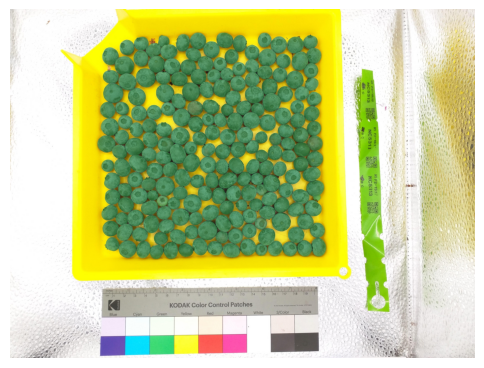

In [9]:
%matplotlib inline
sv.plot_image(mask_annotated_image,size = (6,6))

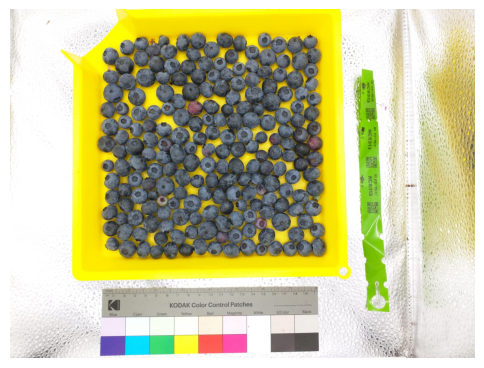

In [10]:
sv.plot_image(image,size = (6,6))

In [13]:
# ['c:\\Users\\sasan\\OneDrive\\Desktop\\CSC630\\aros-blueberry\\blueberry_object_detection-20\\train\\H1-Legacy_F2_14_12A_jpg.rf.f533bb5d1c0a73d9b80676d5b5cd5023.jpg']
object_detection_dataset.annotations[image_name] == detections

KeyError: 'c:\\\\Users\\\\sasan\\\\OneDrive\\\\Desktop\\\\CSC630\\\\aros-blueberry\\\\blueberry_object_detection-20\\\\train\\\\H1-NC5313_F2_15_17A_jpg.rf.2f02ad05c2a744c67fc8920da818c6b6.jpg'

In [145]:
import pycocotools.coco

# Initialize the COCO API.
ANNOTATIONS_FILE_PATH1 = os.path.join(dataset_loc, DATA_SET_SUBDIRECTORY, "_annotations.coco_copy.json")
coco = pycocotools.coco.COCO(ANNOTATIONS_FILE_PATH1)

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [ ]:
# Find the annotation that you want to modify.
ann_id = 12345
ann = coco.loadAnns(ann_id)[0]

# Change the mask value to 100.
ann["mask"] = detections.mask

# Save the COCO annotations file.
coco.save_json("path/to/coco/annotations/instances_train2017.json")

In [177]:
# Find the annotation that has the same image name.
ann_id = coco.getAnnIds(imgIds=coco.getImgIds(image_name.replace(dataset_loc+"\\train\\","")))

# Print the annotation ID.
print(ann_id)

[]


In [186]:
# Iterate over the images list and get the file name and id for each image
image_filenames = []
for i in coco.loadImgs(coco.getImgIds()):
    image_filenames.append((i['id'],i['file_name']))

# Print the image file names and IDs
print(image_filenames)

[(0, 'H1-Legacy_F2_14_12A_jpg.rf.f533bb5d1c0a73d9b80676d5b5cd5023.jpg'), (1, 'NCV-01-2_F2_25_20_jpg.rf.f889f13c8399d0570eec303b0da83ebc.jpg'), (2, 'NC3104_jpg.rf.f746b72db6f26d2719e67f0a7d365d30.jpg'), (3, 'NC5275_H2_5_3_jpg.rf.f4a39b329354254170779dfbc6990b12.jpg'), (4, 'MS1377Delta_F2_22_4_jpg.rf.f6026b7866241614ed654f3f0ece330e.jpg'), (5, 'NewHanover_jpg.rf.f84a247c3e632703400fda73582bf7b2.jpg'), (6, 'H1-Croatan_F2_19_11A_jpg.rf.f7c54171a9c4804c0572a19c72474cb4.jpg'), (7, 'H1-NC5318_F2_16_3B_jpg.rf.fdad09018e7e54f1266398c0be4fa53d.jpg'), (8, 'H2-NC5291_F2_18_13C_jpg.rf.f474bf819d060d4043788d80eb822150.jpg'), (9, 'NC5289_F2_15_10_jpg.rf.07199a5679ece0a043accaf19e48c82d.jpg'), (10, 'H2-NC5316_F2_13_14A_jpg.rf.037bd07dcd6fc482c5fdcd56344173ef.jpg'), (11, 'NC5283_F2_16_14_jpg.rf.060ead37a40cd3f9f67e76f1ab651df1.jpg'), (12, 'H1-NC5274_H2_5_6B_jpg.rf.052803ff21fe8fdf15dd2d0f9b2d97c6.jpg'), (13, 'H2-Suziblue_F2_21_15C_jpg.rf.007f36f28f635fefe26bcbe76fca0306.jpg'), (14, 'ONeal3_jpg.rf.00c68

In [185]:
for i in coco.loadImgs(coco.getImgIds()):
    print(i)
    break

{'id': 0, 'license': 1, 'file_name': 'H1-Legacy_F2_14_12A_jpg.rf.f533bb5d1c0a73d9b80676d5b5cd5023.jpg', 'height': 3120, 'width': 4160, 'date_captured': '2023-09-01T19:44:12+00:00'}


## Testing if Roboflow and SAM are working!

In [ ]:
import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)

In [ ]:
mask_annotator = sv.MaskAnnotator()

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

In [ ]:
print(sam_result[0])

In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(EXAMPLE_IMAGE_PATH)
widget

In [ ]:
widget.bboxes

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'], 
    box['y'], 
    box['x'] + box['width'], 
    box['y'] + box['height']
])

In [ ]:
import cv2

image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.green())
mask_annotator = sv.MaskAnnotator(color=sv.Color.green())

detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks),mask=masks)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
%cd {HOME}

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

In [ ]:
project = rf.workspace("arosphenotyping-nxtf4").project("blueberry_object_detection")
dataset = project.version(20).download("coco")

In [ ]:
DATA_SET_SUBDIRECTORY = "test"
ANNOTATIONS_FILE_NAME = "_annotations.coco.json"
IMAGES_DIRECTORY_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY)
ANNOTATIONS_FILE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, ANNOTATIONS_FILE_NAME)

In [ ]:
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Union, Optional
from dataclasses_json import dataclass_json
from supervision import Detections


@dataclass_json
@dataclass
class COCOCategory:
    id: int
    name: str
    supercategory: str


@dataclass_json
@dataclass
class COCOImage:
    id: int
    width: int
    height: int
    file_name: str
    license: int
    date_captured: str
    coco_url: Optional[str] = None
    flickr_url: Optional[str] = None


@dataclass_json
@dataclass
class COCOAnnotation:
    id: int
    image_id: int
    category_id: int
    segmentation: List[List[float]]
    area: float
    bbox: Tuple[float, float, float, float]
    iscrowd: int


@dataclass_json
@dataclass
class COCOLicense:
    id: int
    name: str
    url: str


@dataclass_json
@dataclass
class COCOJson:
    images: List[COCOImage]
    annotations: List[COCOAnnotation]
    categories: List[COCOCategory]
    licenses: List[COCOLicense]


def load_coco_json(json_file: str) -> COCOJson:
    import json

    with open(json_file, "r") as f:
        json_data = json.load(f)

    return COCOJson.from_dict(json_data)


class COCOJsonUtility:
    @staticmethod
    def get_annotations_by_image_id(coco_data: COCOJson, image_id: int) -> List[COCOAnnotation]:
        return [annotation for annotation in coco_data.annotations if annotation.image_id == image_id]

    @staticmethod
    def get_annotations_by_image_path(coco_data: COCOJson, image_path: str) -> Optional[List[COCOAnnotation]]:
        image = COCOJsonUtility.get_image_by_path(coco_data, image_path)
        if image:
            return COCOJsonUtility.get_annotations_by_image_id(coco_data, image.id)
        else:
            return None

    @staticmethod
    def get_image_by_path(coco_data: COCOJson, image_path: str) -> Optional[COCOImage]:
        for image in coco_data.images:
            if image.file_name == image_path:
                return image
        return None

    @staticmethod
    def annotations2detections(annotations: List[COCOAnnotation]) -> Detections:
        class_id, xyxy = [], []

        for annotation in annotations:
            x_min, y_min, width, height = annotation.bbox
            class_id.append(annotation.category_id)
            xyxy.append([
                x_min,
                y_min,
                x_min + width,
                y_min + height
            ])

        return Detections(
            xyxy=np.array(xyxy, dtype=int),
            class_id=np.array(class_id, dtype=int)
        )


In [ ]:
coco_data = load_coco_json(json_file=ANNOTATIONS_FILE_PATH)

CLASSES = [
    category.name
    for category
    in coco_data.categories
    if category.supercategory != 'none'
]

IMAGES = [
    image.file_name
    for image
    in coco_data.images
]

In [ ]:
CLASSES

In [ ]:
import random
random.seed(2023)

In [ ]:
EXAMPLE_IMAGE_NAME = random.choice(IMAGES)
EXAMPLE_IMAGE_PATH = os.path.join(dataset.location, DATA_SET_SUBDIRECTORY, EXAMPLE_IMAGE_NAME)

# load dataset annotations
annotations = COCOJsonUtility.get_annotations_by_image_path(coco_data=coco_data, image_path=EXAMPLE_IMAGE_NAME)
ground_truth = COCOJsonUtility.annotations2detections(annotations=annotations)

# small hack - coco numerate classes from 1, model from 0 + we drop first redundant class from coco json
ground_truth.class_id = ground_truth.class_id - 1

# load image
image_bgr = cv2.imread(EXAMPLE_IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# initiate annotator
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

# annotate ground truth
annotated_frame_ground_truth = box_annotator.annotate(scene=image_bgr.copy(), detections=ground_truth, skip_label=True)

# run SAM inference
mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=ground_truth.xyxy[0],
    multimask_output=True
)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.mean(detections.area)]
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[annotated_frame_ground_truth, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(image_rgb)